In [56]:
%matplotlib inline
import os
import sys
sys.path.append('/root/capsule/code/beh_ephys_analysis')
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import json
from harp.clock import decode_harp_clock, align_timestamps_to_anchor_points
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import re
from utils.beh_functions import parseSessionID, session_dirs
from utils.plot_utils import shiftedColorMap, template_reorder
from open_ephys.analysis import Session##
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.postprocessing as spost
import spikeinterface.widgets as sw
from aind_dynamic_foraging_basic_analysis.licks.lick_analysis import load_nwb
from aind_ephys_utils import align
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colormaps
from aind_dynamic_foraging_data_utils.nwb_utils import load_nwb_from_filename
import pickle
import datetime


# Create a white-to-bright red colormap
colors = [(1, 1, 1), (1, 0, 0)]  # white to red
my_red = LinearSegmentedColormap.from_list("white_to_red", colors)

In [57]:
session = 'behavior_751004_2024-12-23_14-20-03'
data_type = 'curated'
target = 'soma'

In [58]:
session_dir = session_dirs(session)
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
output_file = os.path.join(session_dir['processed_dir'], f"{session}_process_record.txt")
if not os.path.exists(output_file):
    log_file = open(output_file, "w") 
else: 
    log_file = open(output_file, "a")
sys.stdout = log_file
print(f"Processing {session} data... at {timestamp}")
with open(os.path.join(session_dir['processed_dir'], f"{session}_qm.json"), 'r') as f:
    qm = json.load(f)

## Ephys recording

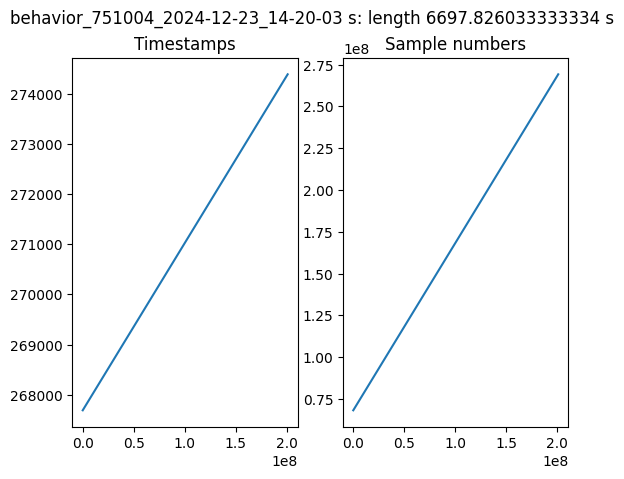

In [59]:
# load neuralpixel session
session_rec = Session(session_dir['session_dir'])
recording = session_rec.recordnodes[0].recordings[0]
timestamps = recording.continuous[0].timestamps
fig = plt.Figure(figsize=(10,2))
plt.subplot(1,2,1)
plt.plot(timestamps[:])
plt.title('Timestamps')
plt.subplot(1,2,2)
plt.plot(recording.continuous[0].sample_numbers)
plt.title('Sample numbers')
plt.suptitle(f'{session} s: length {len(timestamps)/30000} s')
plt.savefig(os.path.join(session_dir['alignment_dir'], f'{session}_timestamps.pdf'))
plt.show()
qm['ephys_local_sync'] = True

In [60]:
# # if needs re-alignment
# ignore_after_time = 1712 # seconds
# recording.add_sync_line(1,            # TTL line number
#                         100,          # processor ID
#                         'ProbeA-AP',  # stream name
#                         main=True,    # set as the main stream
#                         ignore_intervals = [(ignore_after_time * 30000, np.inf)])    

# recording.add_sync_line(1,            # TTL line number                                       
#                         100,          # processor ID
#                         'ProbeA-LFP', # stream name
#                         ignore_intervals = [(ignore_after_time * 2500, np.inf)])

# recording.add_sync_line(1,            # TTL line number
#                         103,          # processor ID
#                         'PXIe-6341',   # stream name
#                         ignore_intervals = [(ignore_after_time * 30000, np.inf)])

# recording.compute_global_timestamps(overwrite=True)

# timestamps = recording.continuous[0].timestamps
# fig = plt.Figure(figsize=(10,2))
# plt.plot(timestamps[:])
# plt.title(f'Recording timestamps: length {len(timestamps)/30000} s')
# plt.show()


In [61]:
# # for NP2.0 if needs re-alignment
# ignore_after_time = 200*60 # seconds
# recording.add_sync_line(1,            # TTL line number
#                         100,          # processor ID
#                         'ProbeA',  # stream name
#                         main=True,    # set as the main stream
#                         ignore_intervals = [(ignore_after_time * 30000, np.inf)])    

# recording.add_sync_line(1,            # TTL line number
#                         124,          # processor ID
#                         'PXIe-6341',   # stream name
#                         ignore_intervals = [(ignore_after_time * 30000, np.inf)])

# recording.compute_global_timestamps(overwrite=True)

# timestamps = recording.continuous[0].timestamps
# fig = plt.Figure(figsize=(10,2))
# plt.plot(timestamps[:])
# plt.title(f'Recording timestamps: length {len(timestamps)/30000} s')
# plt.show()

## Laser 

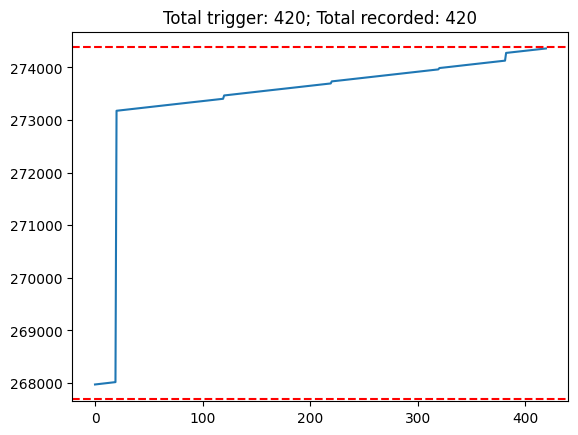

In [62]:
# extract laser times
laser_line = 2
# load all laser conditions
opto_dfs = [pd.read_csv(csv) for csv in session_dir['opto_csvs']]
opto_df = pd.concat(opto_dfs)
opto_df.loc[laser_times < timestamps[int(np.round(len(timestamps) * 0.5))], 'pre_post'] = 'pre'
opto_df.loc[laser_times >= timestamps[int(np.round(len(timestamps) * 0.5))], 'pre_post'] = 'post'
# load all laser times
events = recording.events
laser_events = events[
                (events.stream_name == 'PXIe-6341')
                & (events.line == laser_line)
                & (events.state == 1)
            ].sort_values(by='sample_number')
laser_times = np.sort(laser_events['timestamp'].values)
plt.plot(laser_times)
plt.axhline(y = np.max(timestamps), color = 'r', linestyle = '--')
plt.axhline(y = np.min(timestamps), color = 'r', linestyle = '--')
plt.title(f'Total trigger: {len(opto_df)}; Total recorded: {len(laser_events)}')
plt.savefig(os.path.join(session_dir['opto_dir'], f'{session}_laser_times.pdf'))

In [63]:
# adjustment
if len(laser_times) > len(opto_df):
    qm['laser_same_count'] = False
    Print(f'{session} has more laser triggers than opto_df')
    laser_times = laser_times[1:]
    opto_df = opto_df[:len(laser_times)].copy()
    fig = plt.Figure(figsize=(6,3))
    plt.plot(laser_times)
    plt.axhline(y = np.max(timestamps), color = 'r', linestyle = '--')
    plt.axhline(y = np.min(timestamps), color = 'r', linestyle = '--')
    plt.title(f'Total trigger: {len(opto_df)}; Total recorded: {len(laser_times)}')
elif len(laser_times) < len(opto_df):
    qm['laser_same_count'] = False
    print(f'{session} has more opto_df than laser triggers')
    opto_df = opto_df[:len(laser_times)].copy()
else:
    qm['laser_same_count'] = True
    print(f'{session} has equal number of laser triggers and opto_df')


In [64]:
nwb = load_nwb_from_filename(session_dir[f'nwb_dir_{data_type}'])
unit_qc = nwb.units[:][['ks_unit_id', 'isi_violations_ratio', 'firing_rate', 'presence_ratio', 'amplitude_cutoff', 'decoder_label']]

In [65]:
# load spike times depending on if epyhs is synced
preprosess_qm = os.path.join(session_dir['processed_dir'], f'{session}_qm.json')
if not os.path.exists(preprosess_qm):
    print('No preprocessed quality metrics found. Run behavior_and_time_alignment.py frist.')
with open(preprosess_qm, 'r') as f:
    preprosess_qm = json.load(f)
unit_spikes = nwb.units[:]['spike_times']
unit_ids = nwb.units[:]['ks_unit_id']
if preprosess_qm['ephys_sync']:
    print('Ephys synced, getting spike times from nwb')
else:
    print('Ephys not synced, resync spike times and laser times')
    harp_sync_time = np.load(os.path.join(session_dir['alignment_dir'], 'harp_sync_time.npy'))
    local_sync_time = np.load(os.path.join(session_dir['alignment_dir'], 'local_sync_time.npy'))
    # to be updated
    unit_spikes = [align_timestamps_to_anchor_points(spike_times, local_sync_time, harp_sync_time) for spike_times in unit_spikes]
    laser_times = align_timestamps_to_anchor_points(laser_times, local_sync_time, harp_sync_time)

unit_spikes = {unit_id:unit_spike for unit_id, unit_spike in zip(unit_ids, unit_spikes)}
with open(os.path.join(session_dir['ephys_processed_dir_curated'], 'spiketimes.pkl'), 'wb') as f:
    pickle.dump(unit_spikes, f)

In [66]:
# gather all laser information and save
sites = np.sort(opto_df['site'].unique())
sites = [int(i) for i in sites]
if len(sites) == 1:
    sites = opto_df['emission_location'].unique()
powers = np.sort(opto_df['power'].unique())
powers = [float(i) for i in powers]
num_pulses = np.sort(opto_df['num_pulses'].unique())
num_pulses = [int(i) for i in num_pulses]
freqs = opto_df['param_group'].unique()
freqs = [int(re.search(r'train(.*?)Hz', freq).group(1)) for freq in freqs]
opto_df['freq'] = opto_df['param_group'].apply(lambda x: int(re.search(r'train(.*?)Hz', x).group(1)))
durations = np.sort(opto_df['duration'].unique())
durations = [float(i) for i in durations]
stim_time = opto_df['pre_post'].unique()
print('Sites:')
print(sites)
print('Powers:')
print(powers)
print('Freqs:')
print(freqs)
print('Pulse durations:')
print(durations)
print('Num pulses:')
print(num_pulses)
print('Stim times')
print(stim_time)
stim_params = {'sites': list(sites) , 
                'powers': list(powers), 
                'freqs': list(freqs),
                'durations': list(durations),
                'num_pulses': list(num_pulses),
                'pre_post': list(stim_time)}

In [67]:
# Collect all target laser times and conditions
# save all confirmed laser times
opto_df['time'] = laser_times
if 'emission_location' in opto_df.columns:
    opto_df = opto_df.drop(columns=['site'])
    opto_df['site'] = opto_df['emission_location']
opto_df.to_csv(os.path.join(session_dir['opto_dir'], f'{session}_opto_session.csv'), index=False)

opto_info = stim_params
opto_info['dimensions'] = ['power', 'site', 'num_pulses', 'duration', 'freq', 'pre_post']

with open(os.path.join(session_dir['opto_dir'], f'{session}_opto_info.json'), 'w') as f:
    json.dump(opto_info, f)

# save all focus laser conditions
if target == 'soma':
    resp_win = 25/1000 # seconds
    if 'emission_location' in opto_df.columns:
        opto_df_target = opto_df.query('site == "surface" or site == "surface_LC"')
    else:
        opto_df_target = opto_df
elif target == 'axon':
    resp_win = 50/1000 # seconds
    if 'emission_location' in opto_df.columns:
        opto_df_target = opto_df.query('site != "surface" and site != "surface_LC"')
    else:
        print('No axon data available')
        

opto_df_target.to_csv(os.path.join(session_dir['opto_dir'], f'{session}_opto_session_{target}.csv'), index=False)

opto_info_target = {
    'sites': list(opto_df_target['site'].unique()),
    'powers': list(map(int,np.sort(opto_df_target['power'].unique()))),
    'freqs': list(map(int, np.sort(opto_df_target['freq'].unique()))),  # Convert to Python int
    'durations': list(map(int, np.sort(opto_df_target['duration'].unique()))),
    'num_pulses': list(map(int, np.sort(opto_df_target['num_pulses'].unique()))),
    'pre_post': list(np.sort(opto_df_target['pre_post'].unique()))  # Convert to Python int
}

opto_info_target['dimensions'] = opto_info['dimensions']
opto_info_target['resp_win'] = resp_win


# write json file
with open(os.path.join(session_dir['opto_dir'], f'{session}_opto_info_{target}.json'), 'w') as f:
    json.dump(opto_info_target, f)


In [68]:
dim_len = [len(opto_df_target[dim].unique()) for dim in opto_info['dimensions']]
print(f'Saving opto_responses: {session}')

resp_p = {}
resp_lat = {}
for curr_id in unit_ids:
    spike_times = unit_spikes[curr_id]
    curr_resp_p = np.empty(tuple(dim_len), dtype=object)
    curr_resp_lat = np.empty(tuple(dim_len), dtype=object)
    for power_ind, curr_power in enumerate(np.sort(opto_df_target['power'].unique())):
        for site_ind, curr_site in enumerate(opto_df_target['site'].unique()):                                                             
            for duration_ind, curr_duration in enumerate(np.sort(opto_df_target['duration'].unique())):
                for freq_ind, curr_freq in enumerate(np.sort(opto_df_target['freq'].unique())):
                    for stim_time_ind, curr_stim_time in enumerate(opto_df_target['pre_post'].unique()):
                        for num_pulse_ind, curr_num_pulses in enumerate(np.sort(opto_df_target['num_pulses'].unique())):
                            laser_times_curr = opto_df_target.query('site == @curr_site and power == @curr_power and duration == @curr_duration and freq == @curr_freq and num_pulses == @curr_num_pulses and pre_post ==@curr_stim_time')['time'].values
                            if len(laser_times_curr) == 0:
                                curr_resp_p[power_ind, site_ind, num_pulse_ind, duration_ind, freq_ind, stim_time_ind] = np.full(curr_num_pulses, np.nan).tolist()
                                curr_resp_lat[power_ind, site_ind, num_pulse_ind, duration_ind, freq_ind, stim_time_ind] = np.full(curr_num_pulses, np.nan).tolist()
                            else:
                                resp_temp = []
                                resp_lat_temp = []
                                for curr_pulse in range(curr_num_pulses):
                                    laser_times_curr_pulse = laser_times_curr + curr_pulse * 1/curr_freq
                                    df = align.to_events(spike_times, laser_times_curr_pulse, (0, resp_win), return_df=True)
                                    resp_temp.append(len(df['event_index'].unique())/len(laser_times_curr_pulse))
                                    if len(df) > 0:
                                        resp_lat_temp.append(np.nanmean(df.groupby('event_index')['time'].min().values))
                                    else:
                                        resp_lat_temp.append(np.nan)
                                
                                curr_resp_lat[power_ind, site_ind, num_pulse_ind, duration_ind, freq_ind, stim_time_ind] = resp_lat_temp
                                curr_resp_p[power_ind, site_ind, num_pulse_ind, duration_ind, freq_ind, stim_time_ind] = resp_temp
    resp_p[curr_id] = curr_resp_p
    resp_lat[curr_id] = curr_resp_lat
    # save to unit_opto_tag
    # np.save(os.path.join(session_dir[f'opto_dir_{data_type}'], f'unit_opto_tag_p_{target}_{curr_id}.npy'), curr_resp_p)  
    # np.save(os.path.join(session_dir[f'opto_dir_{data_type}'], f'unit_opto_tag_lat_{target}_{curr_id}.npy'), curr_resp_lat)  
    # np.save(os.path.join(session_dir[f'opto_dir_{data_type}'], f'spiketimes_{curr_id}.npy'), spike_times)    
    # print(f'Unit {curr_id} done')

with open(os.path.join(session_dir[f'opto_dir_{data_type}'], f'{session}_opto_responses_{target}.pkl'), 'wb') as f:
    pickle.dump(resp_p, f)
    pickle.dump(resp_lat, f)

print(f'Saved opto_responses: {session}')
    


In [69]:
# load waveforms info
we = si.load_sorting_analyzer_or_waveforms(session_dir[f'postprocessed_dir_{data_type}'])
unit_ids = we.sorting.get_unit_ids()
all_templates = we.get_extension("templates").get_data(operator="average")
all_channels = we.sparsity.channel_ids
if all_channels[0].startswith('AP'):
    all_channels_int = np.array([int(channel.split('AP')[-1]) for channel in all_channels])
else:
    all_channels_int = np.array([int(channel.split('CH')[-1]) for channel in all_channels])
unit_spartsiity = we.sparsity.unit_id_to_channel_ids
channel_locations = we.get_channel_locations()
unit_locations = we.load_extension("unit_locations").get_data(outputs="by_unit")
right_left = channel_locations[:, 0]<20

# re-organize templates so that left and right separate
colors = ["blue", "white", "red"]
b_w_r_cmap = LinearSegmentedColormap.from_list("b_w_r", colors)

y_neighbors_to_keep = 3
samples_to_keep = [-30, 60]
orginal_loc = False
waveform_params = {'samples_to_keep': samples_to_keep, 'y_neighbors_to_keep': y_neighbors_to_keep, 'orginal_loc': orginal_loc}
with open(os.path.join(session_dir[f'opto_dir_{data_type}'], f'{session}_waveform_params.json'), 'w') as f:
    json.dump(waveform_params, f)

channel_loc_dict = {channel: channel_loc for channel, channel_loc in zip(all_channels_int, channel_locations)}

# save all re-ordered templates
print(f'Saving templates: {session}')
opto_waveforms = {}
for unit_ind, unit_id in enumerate(unit_ids):
    curr_template = all_templates[unit_ind]
    reordered_template = template_reorder(curr_template, right_left, all_channels_int, sample_to_keep = samples_to_keep, y_neighbors_to_keep = y_neighbors_to_keep, orginal_loc = orginal_loc)
    # shifted_cmap = shiftedColorMap(custom_cmap, np.nanmin(reordered_template), np.nanmax(reordered_template), 'shifted_b_w_r')
    # plt.imshow(reordered_template, extent = [-30, -30+2*(30+60), 2*3+1, 0], cmap=shifted_cmap, aspect='auto');
    # plt.axvline(0, color='black', linestyle='--', linewidth=0.5)
    # plt.axvline(30+60, color='black', linestyle='--', linewidth=0.5)
    # plt.title(f'Unit_id: {unit_id} depth: {unit_locations[unit_id][1]:.2f}')
    # plt.box(False)
    # plt.colorbar();
    # np.save(os.path.join(session_dir[f'opto_dir_{data_type}'], f'unit_waveform_{unit_id}.npy'), reordered_template)
    opto_waveforms[unit_id] = reordered_template

with open(os.path.join(session_dir[f'opto_dir_{data_type}'], f'{session}_waveforms_{data_type}.pkl'), 'wb') as f:
    pickle.dump(opto_waveforms, f)
print(f'Saved templates: {session}')

In [73]:
# %%
qm_file = os.path.join(session_dir['processed_dir'], f"{session}_qm.json")
with open(qm_file, 'w') as f:
    json.dump(qm, f, indent=4)
print(f"Output saved to {output_file}")
sys.stdout = sys.__stdout__
# Close the file
log_file.close()